In [1]:
# Cell 1: imports & basic settings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Show more columns/rows if needed
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

In [2]:
# Cell 2: load result CSV

# pct return
csv_path = "/home/rguan/project/ML-Capstone-Team-7/FinTSBridge_models/TSLib_baseline/results/long_term_forecast_WTI_512_6_PatchTST_custom_ftMS_sl512_ll48_pl6_dm512_nh8_el2_dl1_df2048_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0/data_table.csv" 
# # log return
# csv_path = "/home/rguan/project/ML-Capstone-Team-7/FinTSBridge_models/TSLib_baseline/results/long_term_forecast_WTI-log_512_6_PatchTST_PatchTST_custom_ftMS_sl512_ll48_pl6_dm128_nh8_el2_dl1_df256_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0/data_table.csv"
df = pd.read_csv(csv_path)

# Try to parse date column if exists
if "date" in df.columns:
    try:
        df["date"] = pd.to_datetime(df["date"])
    except Exception as e:
        print("Warning: cannot parse date column:", e)

df.head()


,date,true_0,true_1,true_2,true_3,true_4,true_5,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5
0,2017-05-03,0.001211,-0.013100,0.007351,-0.009933,-0.024161,0.003357,-0.002218,0.002096,0.007687,-0.001942,-0.001189,0.003325
1,2017-05-04,-0.013100,0.007351,-0.009933,-0.024161,0.003357,-0.048097,-0.003134,0.002070,0.002430,-0.001654,-0.002171,0.003786
2,2017-05-05,0.007351,-0.009933,-0.024161,0.003357,-0.048097,0.015378,0.000662,-0.000778,0.005074,-0.002812,0.000940,0.002198
3,2017-05-08,-0.009933,-0.024161,0.003357,-0.048097,0.015378,0.004544,-0.004792,0.002050,0.002226,-0.002048,0.001857,0.004096
4,2017-05-09,-0.024161,0.003357,-0.048097,0.015378,0.004544,-0.011846,-0.003374,0.000393,0.003672,-0.001682,-0.000089,0.002419


In [3]:
# Cell 3: helper function to compute metrics

def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray):
    """
    Compute basic regression and directional metrics.
    y_true, y_pred: 1D numpy arrays
    Returns a dict with mse, mae, rmse, r2, corr, direction_acc, n
    """
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    if len(y_true) == 0:
        return {
            "n": 0,
            "mse": np.nan,
            "mae": np.nan,
            "rmse": np.nan,
            "r2": np.nan,
            "corr": np.nan,
            "direction_acc": np.nan,
        }

    mse = np.mean((y_true - y_pred) ** 2)
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(mse)

    # R^2
    var = np.var(y_true)
    if var == 0:
        r2 = np.nan
    else:
        r2 = 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

    # Pearson correlation
    if len(y_true) > 1:
        corr = np.corrcoef(y_true, y_pred)[0, 1]
    else:
        corr = np.nan

    # Direction accuracy (ignore zero returns)
    dir_mask = (y_true != 0)
    if dir_mask.sum() > 0:
        direction_acc = np.mean(
            np.sign(y_true[dir_mask]) == np.sign(y_pred[dir_mask])
        )
    else:
        direction_acc = np.nan

    return {
        "n": len(y_true),
        "mse": mse,
        "mae": mae,
        "rmse": rmse,
        "r2": r2,
        "corr": corr,
        "direction_acc": direction_acc,
    }


In [4]:
# Cell 4: compute per-horizon and global metrics

# Define horizon mapping
horizons = {
    "H+1": ("true_3", "pred_0"),
    "H+2": ("true_4", "pred_1"),
    "H+3": ("true_5", "pred_2"),
}

all_true = []
all_pred = []

rows = []

print("====== Per-horizon metrics (true_3/4/5 vs pred_0/1/2) ======")
for h_name, (t_col, p_col) in horizons.items():
    if t_col not in df.columns or p_col not in df.columns:
        print(f"[WARN] columns {t_col} or {p_col} not found, skip {h_name}")
        continue

    y_true = df[t_col].to_numpy(dtype=float)
    y_pred = df[p_col].to_numpy(dtype=float)

    all_true.append(y_true)
    all_pred.append(y_pred)

    metrics = compute_metrics(y_true, y_pred)
    rows.append(
        {
            "horizon": h_name,
            **metrics,
        }
    )

    print(
        f"{h_name}: n={metrics['n']}, "
        f"MSE={metrics['mse']:.6f}, "
        f"MAE={metrics['mae']:.6f}, "
        f"RMSE={metrics['rmse']:.6f}, "
        f"R2={metrics['r2']:.4f}, "
        f"Corr={metrics['corr']:.4f}, "
        f"DirAcc={metrics['direction_acc']:.4f}"
    )

# Global metrics: flatten all horizons together
if all_true:
    y_true_all = np.concatenate(all_true)
    y_pred_all = np.concatenate(all_pred)
    global_metrics = compute_metrics(y_true_all, y_pred_all)
    rows.append(
        {
            "horizon": "Global(H+1~H+3)",
            **global_metrics,
        }
    )
    print("\n====== Global metrics (H+1~H+3 flattened) ======")
    print(
        f"Global: n={global_metrics['n']}, "
        f"MSE={global_metrics['mse']:.6f}, "
        f"MAE={global_metrics['mae']:.6f}, "
        f"RMSE={global_metrics['rmse']:.6f}, "
        f"R2={global_metrics['r2']:.4f}, "
        f"Corr={global_metrics['corr']:.4f}, "
        f"DirAcc={global_metrics['direction_acc']:.4f}"
    )

metrics_df = pd.DataFrame(rows)
metrics_df


====== Per-horizon metrics (true_3/4/5 vs pred_0/1/2) ======
H+1: n=2132, MSE=0.006098, MAE=0.021787, RMSE=0.078087, R2=-0.0307, Corr=-0.0234, DirAcc=0.4676
H+2: n=2132, MSE=0.005937, MAE=0.018763, RMSE=0.077052, R2=-0.0036, Corr=0.0167, DirAcc=0.5070
H+3: n=2132, MSE=0.006041, MAE=0.019972, RMSE=0.077721, R2=-0.0211, Corr=0.0299, DirAcc=0.5408

====== Global metrics (H+1~H+3 flattened) ======
Global: n=6396, MSE=0.006025, MAE=0.020174, RMSE=0.077622, R2=-0.0185, Corr=0.0031, DirAcc=0.5052


,horizon,n,mse,mae,rmse,r2,corr,direction_acc
0,H+1,2132,0.006098,0.021787,0.078087,-0.030736,-0.023389,0.467636
1,H+2,2132,0.005937,0.018763,0.077052,-0.003595,0.016693,0.507036
2,H+3,2132,0.006041,0.019972,0.077721,-0.021145,0.029884,0.540807
3,Global(H+1~H+3),6396,0.006025,0.020174,0.077622,-0.018492,0.003077,0.505159


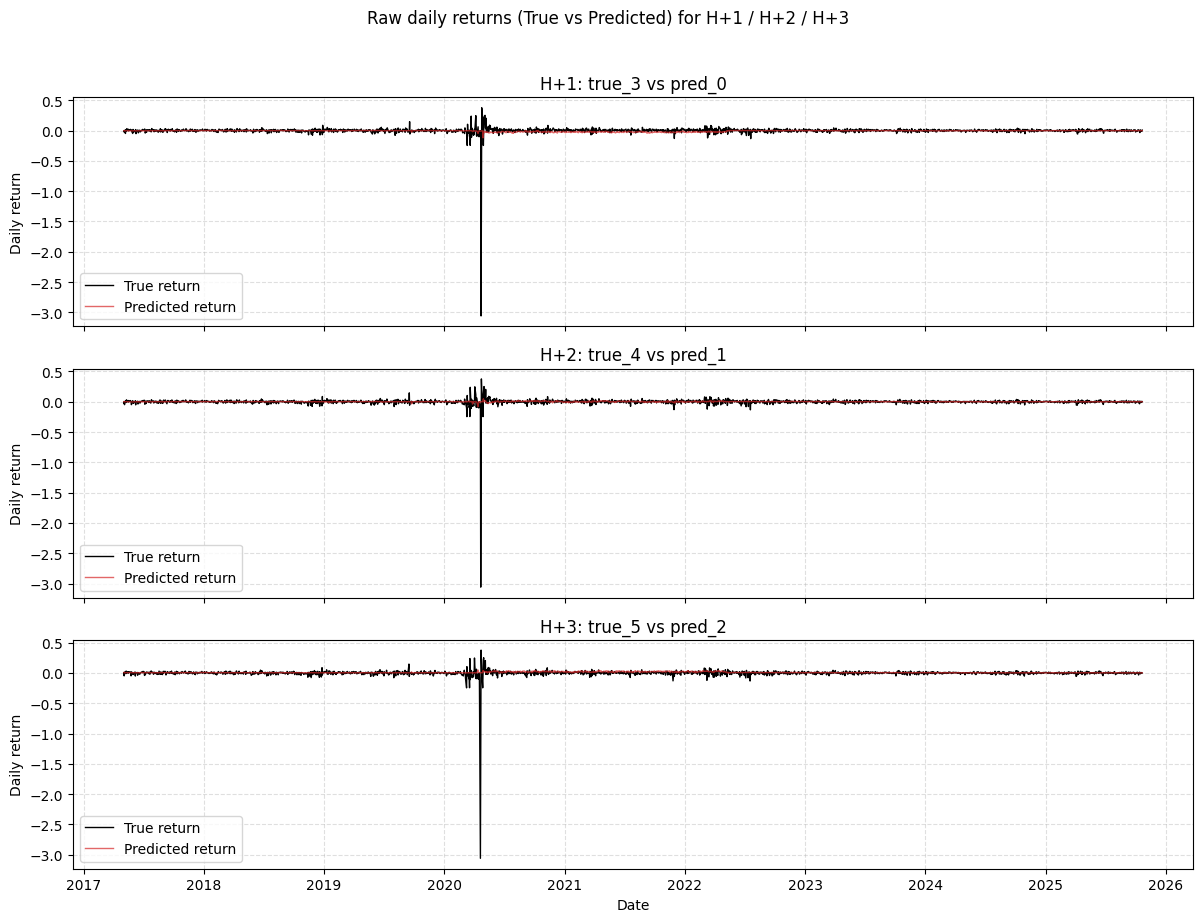

In [6]:
# Cell X: plot raw (non-cumulative) returns for H+1 / H+2 / H+3

import matplotlib.pyplot as plt
import numpy as np

# 映射关系
horizon_map = {
    "H+1": ("true_3", "pred_0"),
    "H+2": ("true_4", "pred_1"),
    "H+3": ("true_5", "pred_2"),
}

# 创建三张子图（每个 horizon 一张）
fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

has_date = "date" in df.columns
if has_date:
    x_all = df["date"].to_numpy()
else:
    x_all = np.arange(len(df))

for ax, (h_name, (t_col, p_col)) in zip(axes, horizon_map.items()):
    if t_col not in df.columns or p_col not in df.columns:
        ax.set_title(f"{h_name}: missing {t_col}/{p_col}")
        ax.axis("off")
        continue

    y_true = df[t_col].to_numpy(dtype=float)
    y_pred = df[p_col].to_numpy(dtype=float)

    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    x = x_all[mask]

    if len(y_true) == 0:
        ax.set_title(f"{h_name}: no valid data")
        ax.axis("off")
        continue

    ax.plot(x, y_true, label="True return", color="black", linewidth=1)
    ax.plot(x, y_pred, label="Predicted return", color="tab:red", linewidth=1, alpha=0.7)

    ax.set_title(f"{h_name}: {t_col} vs {p_col}")
    ax.set_ylabel("Daily return")
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend()

if has_date:
    axes[-1].set_xlabel("Date")
else:
    axes[-1].set_xlabel("Index")

fig.suptitle("Raw daily returns (True vs Predicted) for H+1 / H+2 / H+3", y=1.02)
plt.tight_layout()
plt.show()


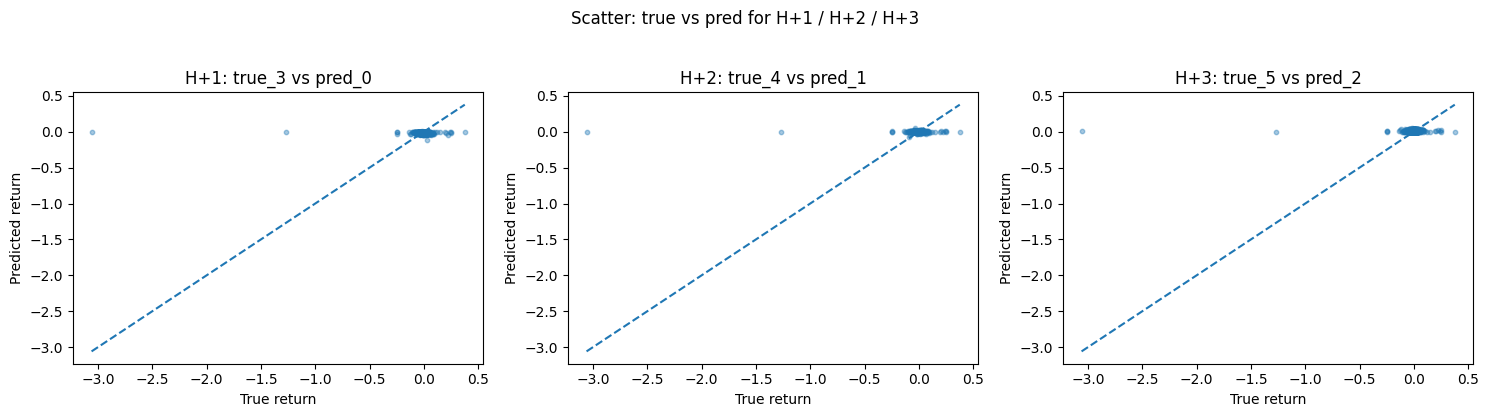

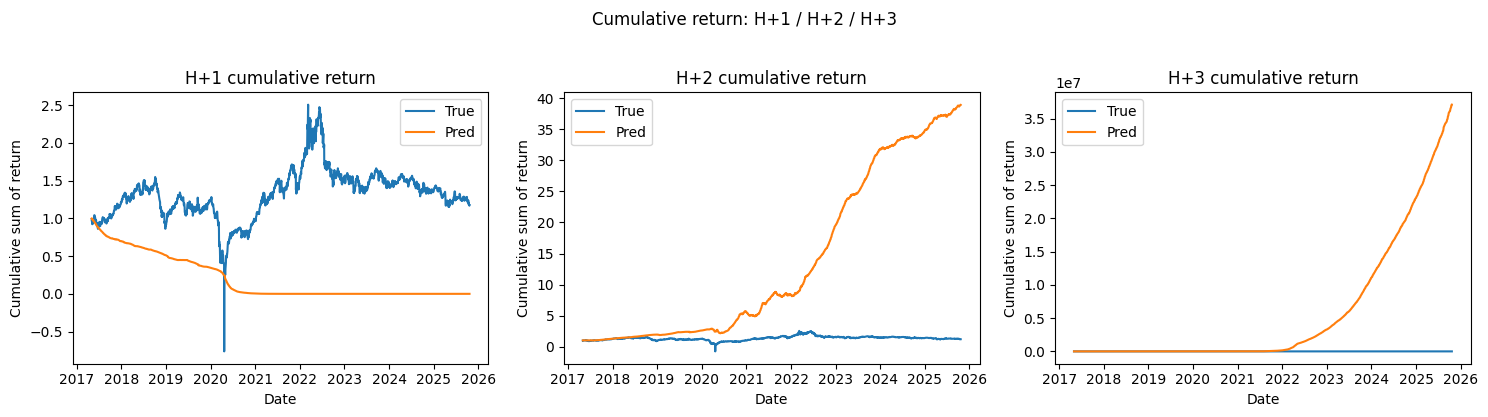

In [10]:
# Cell X: 3 horizons (H+1, H+2, H+3) scatter + cumulative return plots
import numpy as np
import matplotlib.pyplot as plt

# 映射关系：
#   H+1: true_3 vs pred_0
#   H+2: true_4 vs pred_1
#   H+3: true_5 vs pred_2
horizon_map = {
    "H+1": ("true_3", "pred_0"),
    "H+2": ("true_4", "pred_1"),
    "H+3": ("true_5", "pred_2"),
}

# ========= 1) 三个 horizon 的散点图 =========
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (h_name, (t_col, p_col)) in zip(axes, horizon_map.items()):
    if t_col not in df.columns or p_col not in df.columns:
        ax.set_title(f"{h_name}: missing {t_col}/{p_col}")
        ax.axis("off")
        continue

    y_true = df[t_col].to_numpy(dtype=float)
    y_pred = df[p_col].to_numpy(dtype=float)
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    if len(y_true) == 0:
        ax.set_title(f"{h_name}: no valid points")
        ax.axis("off")
        continue

    ax.scatter(y_true, y_pred, alpha=0.4, s=10)

    # 画 y=x 参考线
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], linestyle="--")

    ax.set_xlabel("True return")
    ax.set_ylabel("Predicted return")
    ax.set_title(f"{h_name}: {t_col} vs {p_col}")

fig.suptitle("Scatter: true vs pred for H+1 / H+2 / H+3", y=1.03)
plt.tight_layout()
plt.show()


# ========= 2) 三个 horizon 的累计收益曲线 =========
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

has_date = "date" in df.columns
if has_date:
    x_all = df["date"].to_numpy()
else:
    x_all = np.arange(len(df))

for ax, (h_name, (t_col, p_col)) in zip(axes, horizon_map.items()):
    if t_col not in df.columns or p_col not in df.columns:
        ax.set_title(f"{h_name}: missing {t_col}/{p_col}")
        ax.axis("off")
        continue

    y_true = df[t_col].to_numpy(dtype=float)
    y_pred = df[p_col].to_numpy(dtype=float)

    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    x = x_all[mask]

    if len(y_true) == 0:
        ax.set_title(f"{h_name}: no valid points")
        ax.axis("off")
        continue

    cum_true = np.cumprod(1+y_true)
    cum_pred = np.cumprod(1+y_pred)

    ax.plot(x, cum_true, label="True")
    ax.plot(x, cum_pred, label="Pred")

    ax.set_title(f"{h_name} cumulative return")
    ax.set_xlabel("Date" if has_date else "Index")
    ax.set_ylabel("Cumulative sum of return")
    ax.legend()

fig.suptitle("Cumulative return: H+1 / H+2 / H+3", y=1.03)
plt.tight_layout()
plt.show()


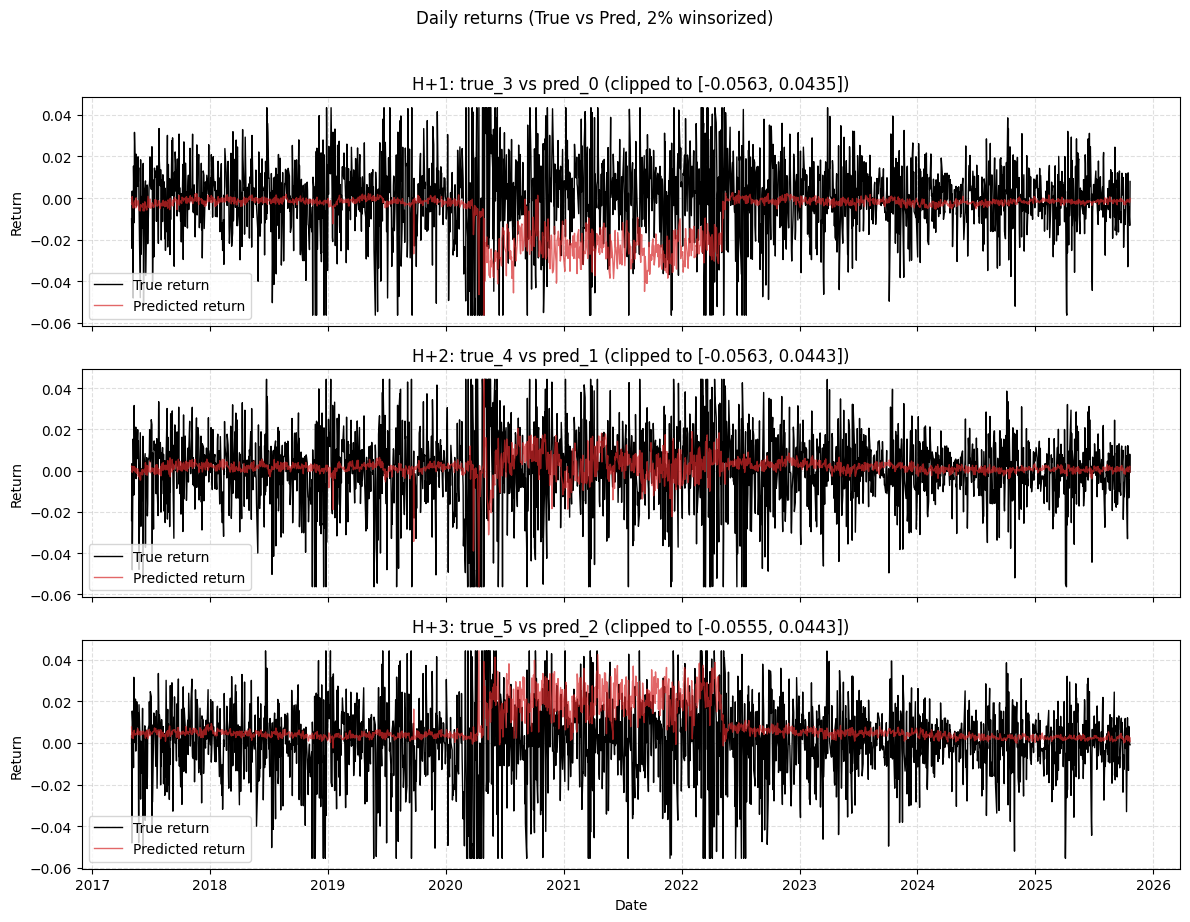

In [7]:
# Cell X: plot raw returns with outlier clipping (winsorized)

import matplotlib.pyplot as plt
import numpy as np

horizon_map = {
    "H+1": ("true_3", "pred_0"),
    "H+2": ("true_4", "pred_1"),
    "H+3": ("true_5", "pred_2"),
}

# -------- 可调参数：去极值百分比 --------
lower_pct, upper_pct = 1, 99  # 保留中间 98% 的数据
# --------------------------------------

def clip_outliers(y_true, y_pred, low, high):
    """对 y_true 和 y_pred 同时 clip 到指定分位数范围"""
    combined = np.concatenate([y_true, y_pred])
    lower, upper = np.percentile(combined, [low, high])
    return np.clip(y_true, lower, upper), np.clip(y_pred, lower, upper), (lower, upper)

fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

has_date = "date" in df.columns
if has_date:
    x_all = df["date"].to_numpy()
else:
    x_all = np.arange(len(df))

for ax, (h_name, (t_col, p_col)) in zip(axes, horizon_map.items()):
    if t_col not in df.columns or p_col not in df.columns:
        ax.set_title(f"{h_name}: missing {t_col}/{p_col}")
        ax.axis("off")
        continue

    y_true = df[t_col].to_numpy(dtype=float)
    y_pred = df[p_col].to_numpy(dtype=float)

    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    x = x_all[mask]

    if len(y_true) == 0:
        ax.set_title(f"{h_name}: no valid data")
        ax.axis("off")
        continue

    # 去除极端值
    y_true_clipped, y_pred_clipped, bounds = clip_outliers(y_true, y_pred, lower_pct, upper_pct)
    lower, upper = bounds

    ax.plot(x, y_true_clipped, label="True return", color="black", linewidth=1)
    ax.plot(x, y_pred_clipped, label="Predicted return", color="tab:red", linewidth=1, alpha=0.7)
    ax.set_title(f"{h_name}: {t_col} vs {p_col} (clipped to [{lower:.4f}, {upper:.4f}])")
    ax.set_ylabel("Return")
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend()

if has_date:
    axes[-1].set_xlabel("Date")
else:
    axes[-1].set_xlabel("Index")

fig.suptitle(f"Daily returns (True vs Pred, {100-upper_pct+lower_pct:.0f}% winsorized)", y=1.02)
plt.tight_layout()
plt.show()


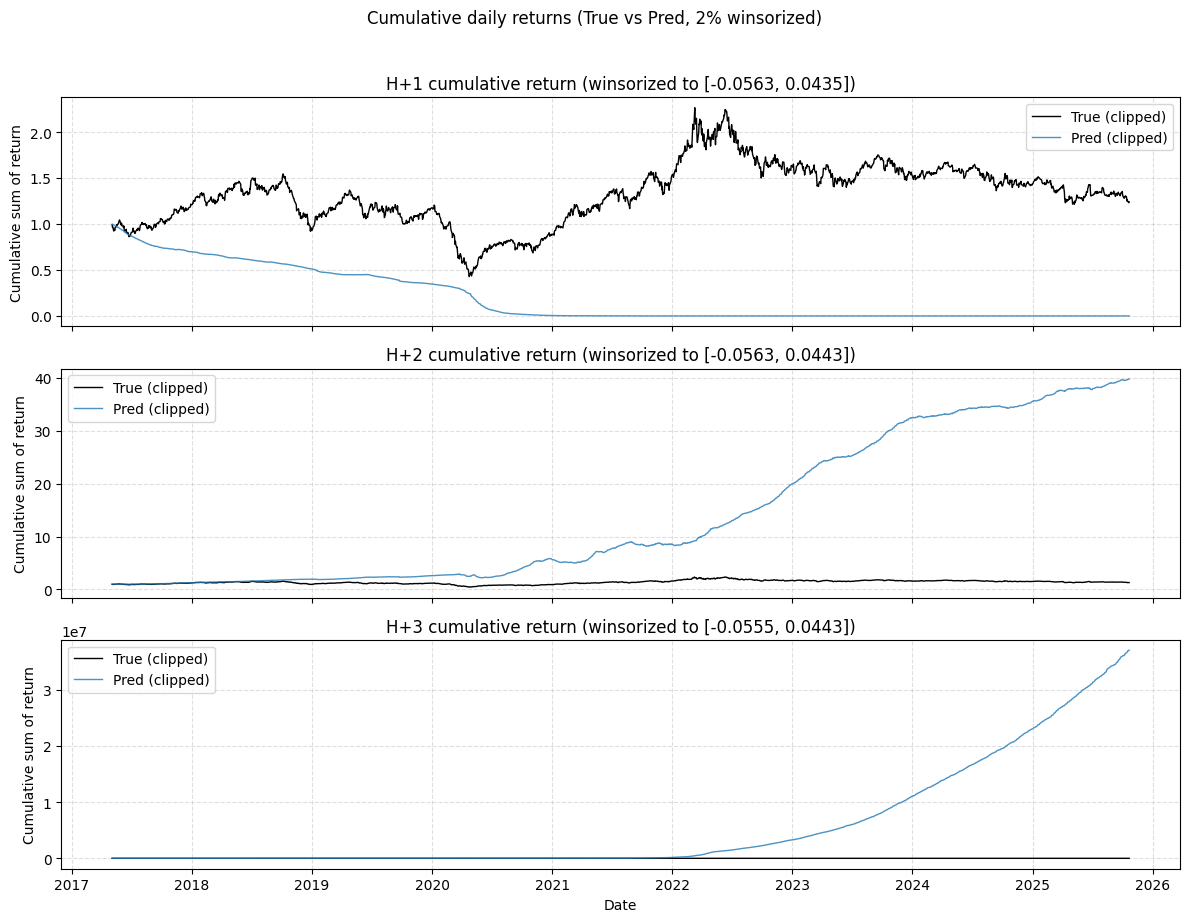

In [9]:
# Cell X: cumulative return (winsorized) for H+1 / H+2 / H+3

import numpy as np
import matplotlib.pyplot as plt

# 映射关系：预测的是 true_3/4/5，对应 pred_0/1/2
horizon_map = {
    "H+1": ("true_3", "pred_0"),
    "H+2": ("true_4", "pred_1"),
    "H+3": ("true_5", "pred_2"),
}

# -------- 可调参数：去极值百分比 --------
lower_pct, upper_pct = 1, 99  # 保留中间 98% 的 return
# --------------------------------------

def clip_outliers(y_true, y_pred, low, high):
    """
    对 y_true 和 y_pred 同时做 winsorize：
    按联合分布计算分位数，然后把两边的 tail 裁到 [low, high] 区间。
    """
    combined = np.concatenate([y_true, y_pred])
    lower, upper = np.percentile(combined, [low, high])
    return np.clip(y_true, lower, upper), np.clip(y_pred, lower, upper), (lower, upper)

fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

has_date = "date" in df.columns
if has_date:
    x_all = df["date"].to_numpy()
else:
    x_all = np.arange(len(df))

for ax, (h_name, (t_col, p_col)) in zip(axes, horizon_map.items()):
    if t_col not in df.columns or p_col not in df.columns:
        ax.set_title(f"{h_name}: missing {t_col}/{p_col}")
        ax.axis("off")
        continue

    y_true = df[t_col].to_numpy(dtype=float)
    y_pred = df[p_col].to_numpy(dtype=float)

    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    x = x_all[mask]

    if len(y_true) == 0:
        ax.set_title(f"{h_name}: no valid data")
        ax.axis("off")
        continue

    # 去极值（winsorize）
    y_true_clip, y_pred_clip, bounds = clip_outliers(y_true, y_pred, lower_pct, upper_pct)
    lower, upper = bounds

    # 这里用 cumulative sum 近似累计收益（如果是 log-return 就正好是累计 log-return）
    cum_true = np.cumprod(1 + y_true_clip)
    cum_pred = np.cumprod(1 + y_pred_clip)

    # 👉 如果你想看“资金曲线”，可以改成：
    # equity_true = np.cumprod(1 + y_true_clip) - 1
    # equity_pred = np.cumprod(1 + y_pred_clip) - 1
    # 然后把下面的 cum_true/cum_pred 换成 equity_true/equity_pred

    ax.plot(x, cum_true, label="True (clipped)", color="black", linewidth=1)
    ax.plot(x, cum_pred, label="Pred (clipped)", color="tab:blue", linewidth=1, alpha=0.8)

    ax.set_title(
        f"{h_name} cumulative return (winsorized to [{lower:.4f}, {upper:.4f}])"
    )
    ax.set_ylabel("Cumulative sum of return")
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend()

if has_date:
    axes[-1].set_xlabel("Date")
else:
    axes[-1].set_xlabel("Index")

fig.suptitle(
    f"Cumulative daily returns (True vs Pred, {100-upper_pct+lower_pct:.0f}% winsorized)",
    y=1.02
)
plt.tight_layout()
plt.show()
